# Install packages

In [1]:
!pip install diffusers
!pip install accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

# Prepare data

In [2]:
# prerequisites
from tqdm.auto import tqdm
import os
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from dataclasses import dataclass

# HuggingFace
import diffusers
import accelerate
from accelerate import Accelerator

bs = 100
device = "cuda"

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 904923.88it/s] 


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 130333.46it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1092703.75it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4383462.67it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



# Helper functions

In [ ]:
# Generate samples from each model
def generate_VAE_samples(model, dim, num_samples=10, device=device):
    model.eval()
    noise = torch.randn(num_samples, dim, device=device)
    with torch.no_grad():
        samples = model.decoder(noise)
    return samples.cpu().numpy()

def generate_GAN_samples(model, dim, num_samples=10, device=device):
    model.eval()
    noise = torch.randn(num_samples, dim, device=device)
    with torch.no_grad():
        samples = model(noise)
    return samples.cpu().numpy()

# Plotting function
def plot_samples(samples, title, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    fig.suptitle(title, fontsize=16)
    for i in range(num_samples):
        axes[i].imshow(samples[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.show()

# VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2).to(device)
# Define the optimizer
optimizer = optim.Adam(vae.parameters())
# Define the loss function to be reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(5):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 545.662461
Train Epoch: 0 [10000/60000 (17%)]	Loss: 183.264492
Train Epoch: 0 [20000/60000 (33%)]	Loss: 167.277949
Train Epoch: 0 [30000/60000 (50%)]	Loss: 164.720684
Train Epoch: 0 [40000/60000 (67%)]	Loss: 161.889902
Train Epoch: 0 [50000/60000 (83%)]	Loss: 169.784961
====> Epoch: 0 Average loss: 178.9253
====> Test set loss: 161.8181
Train Epoch: 1 [0/60000 (0%)]	Loss: 151.566689
Train Epoch: 1 [10000/60000 (17%)]	Loss: 157.602842
Train Epoch: 1 [20000/60000 (33%)]	Loss: 159.712695
Train Epoch: 1 [30000/60000 (50%)]	Loss: 158.557266
Train Epoch: 1 [40000/60000 (67%)]	Loss: 160.257256
Train Epoch: 1 [50000/60000 (83%)]	Loss: 155.871084
====> Epoch: 1 Average loss: 157.4789
====> Test set loss: 154.1530
Train Epoch: 2 [0/60000 (0%)]	Loss: 156.218564
Train Epoch: 2 [10000/60000 (17%)]	Loss: 155.076318
Train Epoch: 2 [20000/60000 (33%)]	Loss: 146.028193
Train Epoch: 2 [30000/60000 (50%)]	Loss: 154.644375
Train Epoch: 2 [40000/60000 (67%)]	Loss: 149.66

## Sampling

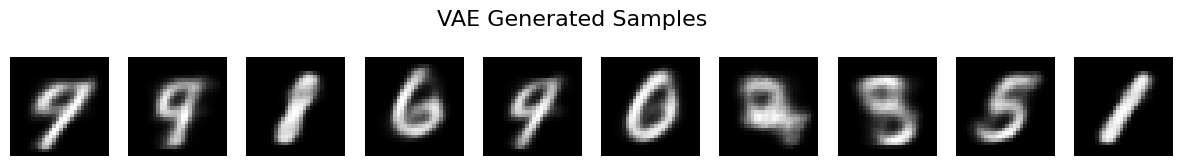

In [ ]:
VAE_samples = generate_VAE_samples(model=vae, dim=2)
plot_samples(VAE_samples, "VAE Generated Samples")

# GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [ ]:
n_epoch = 20
for epoch in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/20]: loss_d: 0.723, loss_g: 2.085
[2/20]: loss_d: 0.710, loss_g: 2.238
[3/20]: loss_d: 0.725, loss_g: 2.230
[4/20]: loss_d: 0.735, loss_g: 2.061
[5/20]: loss_d: 0.685, loss_g: 2.132
[6/20]: loss_d: 0.743, loss_g: 2.048
[7/20]: loss_d: 0.725, loss_g: 2.228
[8/20]: loss_d: 0.703, loss_g: 2.194
[9/20]: loss_d: 0.671, loss_g: 2.381
[10/20]: loss_d: 0.668, loss_g: 2.199
[11/20]: loss_d: 0.664, loss_g: 2.355
[12/20]: loss_d: 0.701, loss_g: 2.235
[13/20]: loss_d: 0.655, loss_g: 2.274
[14/20]: loss_d: 0.641, loss_g: 2.279
[15/20]: loss_d: 0.675, loss_g: 2.267
[16/20]: loss_d: 0.611, loss_g: 2.450
[17/20]: loss_d: 0.615, loss_g: 2.455
[18/20]: loss_d: 0.617, loss_g: 2.406
[19/20]: loss_d: 0.583, loss_g: 2.508
[20/20]: loss_d: 0.572, loss_g: 2.607


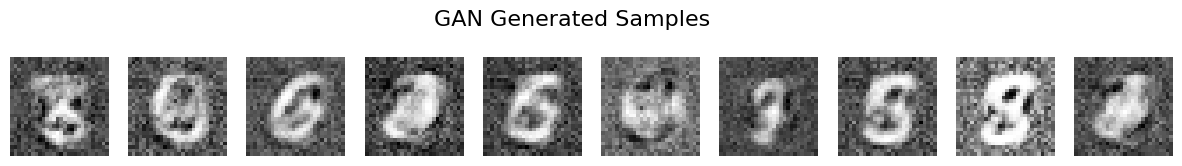

In [ ]:
GAN_samples = generate_GAN_samples(G, dim=z_dim)
plot_samples(GAN_samples, "GAN Generated Samples")

# Diffusion

### Training configuration

In [3]:
@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 32
    eval_batch_size = 32  # how many images to sample during evaluation
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "mnist"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

### loading the dataset

In [4]:
from datasets import load_dataset

mnist_dataset = load_dataset('mnist', split='train')

def transform(dataset):
    preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(
                (config.image_size, config.image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: 2*(x-0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}
mnist_dataset.reset_format()
mnist_dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Creating the model and noise_scheduler

In [5]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=1000)


/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


### Train the model

In [6]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [7]:
from tqdm.auto import tqdm
from pathlib import Path
import os



def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1


In [16]:
import torch

# Assuming 'model' and 'noise_scheduler' are already trained and defined
model_save_path = "unet2d_model.pth"

# Save the model state dictionary
torch.save(model.state_dict(), model_save_path)

# Save the noise scheduler state dictionary
# torch.save(noise_scheduler.state_dict(), noise_scheduler_save_path)


In [ ]:
model.load_state_dict(torch.load("unet2d_model.pth"))


<All keys matched successfully>

In [12]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

### Generating samples

In [10]:
@torch.no_grad()
def sample(unet, scheduler,seed,save_process_dir=None):
    device = "cuda"
    unet.to(device)
    unet.eval()
    torch.manual_seed(seed)


    scheduler.set_timesteps(1000)
    image=torch.randn((1,1,32,32)).to(device)
    num_steps=max(noise_scheduler.timesteps).numpy()

    for t in noise_scheduler.timesteps:
        model_output=unet(image,t)['sample']
        image=scheduler.step(model_output,int(t),image,generator=None)['prev_sample']

    return torchvision.transforms.ToPILImage()(image.squeeze(0))

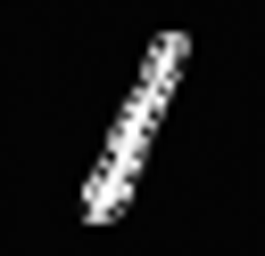

In [14]:
test_image=sample(model,noise_scheduler,2)
test_image.resize((265,256))